In [112]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [113]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [114]:
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 25
LOSS_FUNCTION = nn.MSELoss()
LOWEST_LOSS = float('inf')

In [115]:
y_loss = {}
y_loss['train'] = []
y_loss['test'] = []

X_epochs = []

In [116]:
def data_workflow(input_data, target_value):
    X = input_data.drop([target_value], axis=1)
    y = input_data[target_value]

    #print(X)
    #print(y)

    X = X.to_numpy()
    y = y.to_numpy()

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    data = TensorDataset(X, y)

    train_ds, test_ds = train_test_split(data, test_size=0.2, random_state=25)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

    print(f"training data: {train_dl}\n test data: {test_dl}")
    return train_dl, test_dl
    



In [117]:
csv_filepath = "./final_harvest_data.csv"

data = pd.read_csv(csv_filepath)
DATA = data.drop(['date', 'index', 'plant_id', 'tray_id', 'row', 'column'], axis=1)

DATA

,LFW_g,LDW_g,LA_mm2,length_mm,width_mm,height_mm,plant_area,plant_convex_hull_area,plant_solidity,plant_perimeter,plant_width,plant_height,plant_longest_path,plant_convex_hull_vertices,plant_ellipse_major_axis,plant_ellipse_minor_axis,plant_ellipse_angle,plant_ellipse_eccentricity
0,1.30,0.078,31.95,4.3,5.2,5.8,1211,1456.0,0.831731,189.923880,49,42,346,16,45.684494,40.965988,92.878510,0.442608
1,2.10,0.148,44.10,5.3,5.7,5.5,1412,1556.5,0.907164,181.338094,56,41,370,20,53.368065,37.484673,96.255425,0.711802
2,3.36,0.196,67.61,7.3,6.5,8.9,1303,1766.5,0.737617,247.865005,49,54,333,19,46.356819,43.059174,2.102176,0.370421
3,3.07,0.184,66.98,5.8,7.6,7.5,1601,1787.0,0.895915,203.480229,44,59,395,21,55.633369,38.548523,15.127802,0.721031
4,3.17,0.187,68.74,7.2,8.0,7.1,1919,2372.0,0.809022,263.421354,62,58,454,19,60.012882,48.875011,55.774792,0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,57.96,3.010,726.46,18.5,18.5,13.0,19084,22974.0,0.830678,767.938160,193,167,1367,33,190.580887,137.733093,62.138748,0.691160
161,81.46,3.880,1001.79,21.0,21.5,14.8,18373,21556.5,0.852318,661.612260,164,189,1317,29,176.040924,141.141724,22.056726,0.597653
162,140.84,6.380,1707.14,23.0,22.5,16.9,23374,26050.0,0.897274,683.754395,186,194,1427,31,191.379974,164.496170,175.959305,0.511091
163,108.17,5.250,1364.18,31.4,20.5,16.6,23457,25678.5,0.913488,671.754395,198,179,1364,31,194.815384,159.870819,122.656914,0.571464


In [118]:
LFW_train, LFW_test = data_workflow(DATA, 'LFW_g')

training data: <torch.utils.data.dataloader.DataLoader object at 0x7f7d1459fee0>
 test data: <torch.utils.data.dataloader.DataLoader object at 0x7f7d14faf250>


In [119]:
def find_best_loss(current_best_val_loss, model_loss):
    if current_best_val_loss > model_loss:
        return model_loss
    else:
        return current_best_val_loss

In [120]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(17, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
            
        ) 

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits.double()
        



In [121]:
model = DeepNeuralNetwork()
model = model.double()
print(model)

DeepNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [122]:
def train_loop(dataset, model, loss_function, optimizer):
    model.train()
    for (X, y) in dataset:
        y = y.view(-1,1) 
        
        model.zero_grad()
        optimizer.zero_grad()

        prediction = model(X)
        loss = loss_function(prediction, y)

        y_loss['train'].append(loss.item())
        

        loss.backward()
        optimizer.step()

        

        

In [123]:
def test_loop(dataset, model, loss_function, optimizer):
    
    for (X, y) in dataset:
        y = y.view(-1,1) 
        
        model.zero_grad()
        optimizer.zero_grad()

        prediction = model(X)
        loss = loss_function(prediction, y)

        y_loss['test'].append(loss.item())

 

        loss.backward()
        optimizer.step()

        
        print(f"Test Loss: {loss}")
        

In [124]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n------------------------------------")
    train_loop(LFW_train, model, LOSS_FUNCTION, optimizer)
    test_loop(LFW_test, model, LOSS_FUNCTION, optimizer)
    X_epochs.append(t)
print("Training complete!")

Epoch 1
------------------------------------
Test Loss: 4209.042321532201
Test Loss: 3720.7745975245
Test Loss: 772.9433342704224
Test Loss: 547.9746246313103
Test Loss: 137.7529671657511
Epoch 2
------------------------------------
Test Loss: 121.78415019415218
Test Loss: 255.77423062298692
Test Loss: 486.900103930846
Test Loss: 198.56165179947183
Test Loss: 340.1978703821931
Epoch 3
------------------------------------
Test Loss: 936.2372514906828
Test Loss: 93.5158252539538
Test Loss: 903.6105562584552
Test Loss: 284.3211110885716
Test Loss: 234.46171950300922
Epoch 4
------------------------------------
Test Loss: 261.5715908158789
Test Loss: 214.9545546513795
Test Loss: 273.65190549272825
Test Loss: 196.77396220160196
Test Loss: 693.3998845853171
Epoch 5
------------------------------------
Test Loss: 240.68355944381494
Test Loss: 345.02230154014956
Test Loss: 900.9569024460665
Test Loss: 874.61747015208
Test Loss: 377.4340725176942
Epoch 6
------------------------------------
Tes

[24876.56613014657, 103234.04672144447, 5360.3468132495345, 3663.5406798085583, 24471.917525899604, 14187.046011444705, 6469.182259042772, 5585.758508304939, 2317.115839108281, 297.32644886810215, 690.6447552985928, 2034.642204420978, 3425.399005104861, 17604.572213550724, 102.11271509718672, 798.7787642027388, 4722.824640448486, 421.1327476154112, 1980.8195116099462, 2520.83455649627, 329.33371726747373, 419.39020990406846, 193.10804258739455, 98.28921890170889, 358.9697297736504, 2375.0855211026806, 1096.1033213194567, 178.88480586697395, 1521.932806391862, 1271.8576828107757, 1405.3079814520036, 1718.4230876977754, 1013.0931241570038, 1084.0664052658963, 751.5346082598593, 874.1058166448178, 1042.1146296081715, 582.749222311518, 394.67452666163496, 125.31467467524686, 826.4369894630124, 108.93751381223504, 1323.082438038753, 223.40787307904728, 87.3754459141539, 1678.9075128609886, 1987.768254339114, 395.80020516100865, 591.7245490336924, 1786.9627960187217, 443.68525730614095, 542.

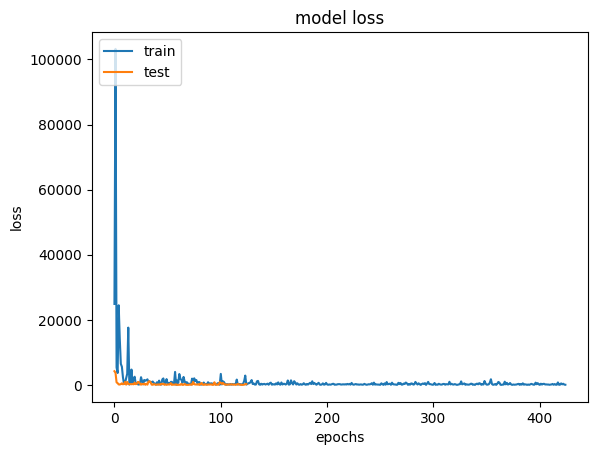

In [125]:
print(y_loss['train'])
plt.plot(y_loss['train'])
plt.plot(y_loss['test'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()